In [38]:
import pandas as pd
from IPython.display import Image, display
from pgmpy.estimators import ExhaustiveSearch
from pgmpy.estimators import K2Score
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch
from pgmpy.base import DAG

In [39]:
df = pd.read_csv('cardiovascular_train.csv')

print(df.columns)

Index(['Age', 'Anxiety', 'BodyMassIndex', 'Depression', 'Diabetes',
       'EducationLevel', 'Hypercholesterolemia', 'Hypertension',
       'PhysicalActivity', 'Sex', 'SleepDuration', 'SmokerProfile',
       'SocioeconomicStatus'],
      dtype='object')


# Structure Learning 

For and effective modeling of a Bayesian Network of CVD, the structure needs to be learned first before estimating the parameters of the network.
This step is crucial to determine which variables are directly connected, indicating the influence and the relationship between variables.

  0%|          | 0/1000000 [00:00<?, ?it/s]

Amount of connections between variables: 48


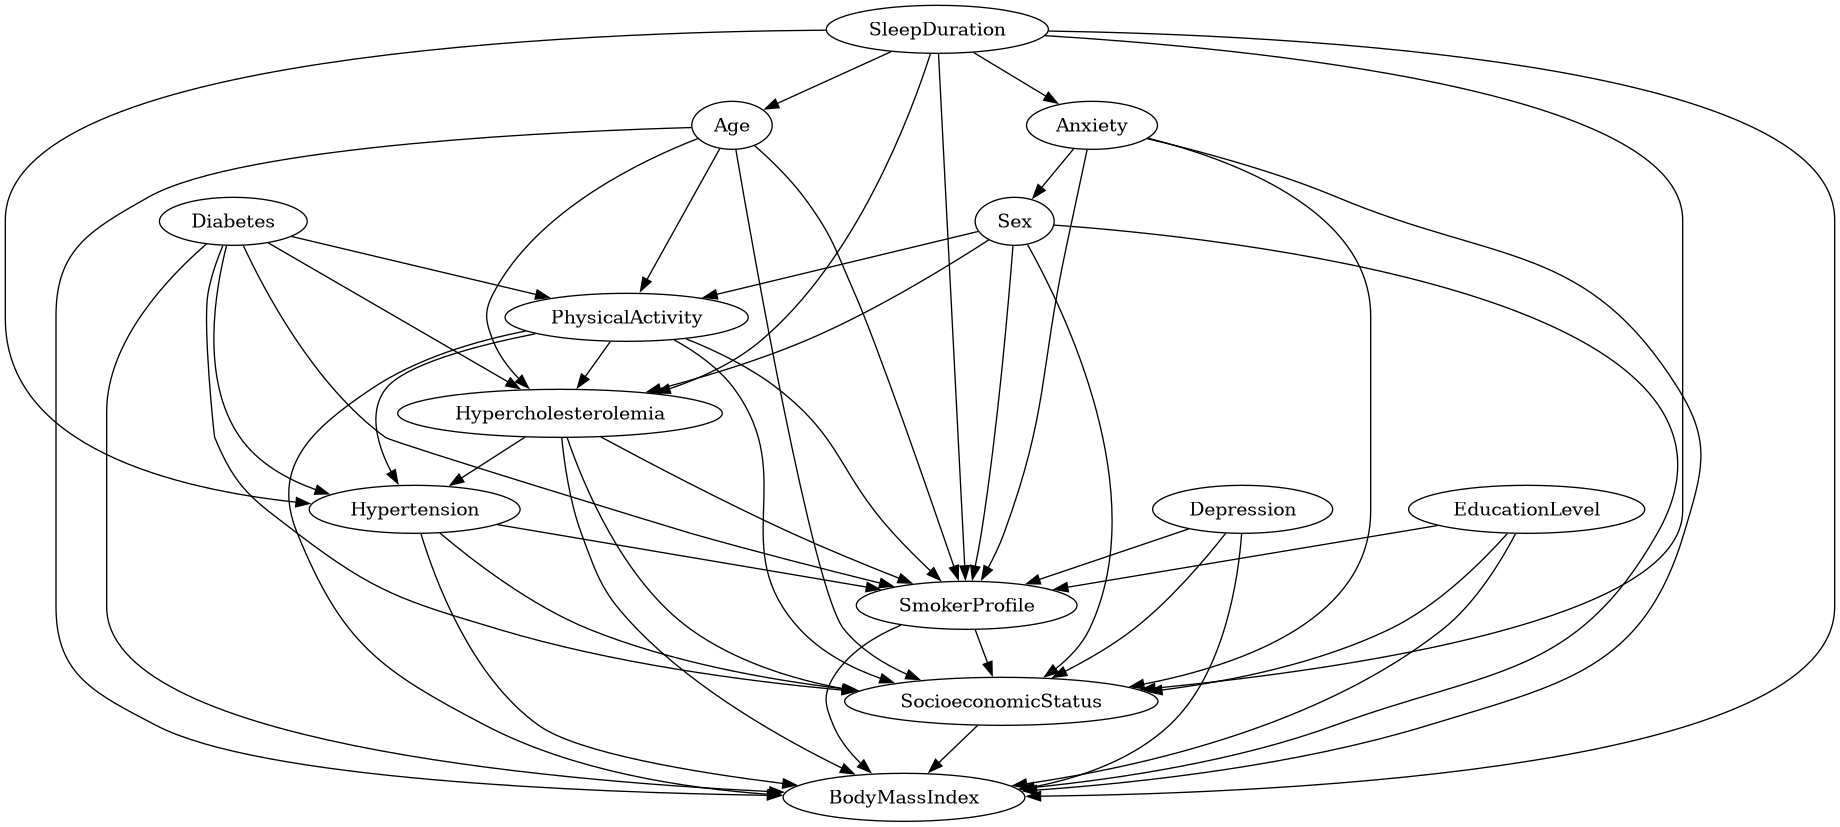

In [40]:
k2 = K2Score(df)
es = HillClimbSearch(data=df)
best_model = es.estimate(scoring_method=k2)
print('Amount of connections between variables:', len(best_model.edges()))
m = best_model.to_graphviz()
img = m.draw(format='png',prog="dot")
display(Image(img))

But trying to learn the structure without implementing some restrictions results in complex network with unecessary connections, that dificults the interpretation of the model.

### Restrictions 

To address this complexety, some restrictions are introduced in form of whitelists (connections that are mandatory) and blacklists (connections that are forbidden).
Theese restrictions, based on some common domain knoledge about what the relationships are likely to be and what variables influence each other, remove some unlikely and redundant connections that were going to complicate the network.

#### Mandatory Connections

Certain connections are strongly supported by research and science and should be mandatory edges in the network. These connections represent a relationship that significantly contributes to CVD risk, such as:

- **Age → Hypertension**: Blood pressure in most cases increases with age due to arterial stiffening, making it most common in older individuals.

- **Age → Hypercholesterolomia**: Cholesterol levels also rise has age increases.

-  **BodyMassIndex → Hypertension**: A Higher BMI, and more specific an obese condition places more stress in the hearth and blood vessels, resulting in a elevated blood pressure.

-  **Anxiety → Hypertension**: Anxiety can lead to a more increased blood pressure due to a more active nervous system and stress hormones.

-  **PhysicalActivity → BodyMassIndex**: Regular physical activity is associated with a lower BMI.

-  **Diabetes → Hypertension**: Diabetes damages blood vessels increasing the risk of developing hypertension.

-  **Depression → PhysicalActivity**: Depression in general cases can influence the ammount of physical activities individuals practice.

#### Forbidden Connections

Also safely omitteed based on science and common knoledge, the "blacklised" connections reduce the risk of redundency

- **Education Level → Hypercholesterolemia**: Education might influence the individual lifestyle but does not have a direct relationship with cholesterol levels.

- **SleepDuration → SocioeconomicStatus**: sleep duration does not determine the socioeconomic status

- **SmokerProfile → EducationLevel**: Smoking status does not affect the and individual's education background.

- **Sex → EducationLevel**:Sex does not impact one's education level.

- **Anxiety → SocioeconomicStatus**: Axienty does not affect SocioeconomicStatus by can vice-versa.

- **PhysicalActivity → SocioeconomicStatus**: gerally does not influence Socioeconimic Status direcly.


#### Independant Variables

Age and Sex can be assumed independent from other variables or considered "root" nodes (without parents) since they are exogenous to the system and only representative of the demographic characteristics by not getting influenced by other factors in the model.

In [41]:
def initialize_graph(nodes,p=1):
  G = DAG()
  G.add_nodes_from(nodes=nodes)
  init = G.get_random(n_nodes=len(nodes), edge_prob=p)
  ls = []
  mapping = {}
  for k in range(len(nodes)):
      mapping[k] = nodes[k]
  for i,j in init.edges:
    ls.append((mapping[i],mapping[j]))
  ls
  G.add_edges_from(ebunch=ls) # G is the required initialization for the Hill Climbing method
  return G

In [55]:


# Load the dataset
df = pd.read_csv('cardiovascular_train.csv')

# Define the scoring method and search method
k2 = K2Score(df)
es = HillClimbSearch(data=df)

# Define whitelist and blacklist edges based on domain knowledge
whitelist = [
    ("Age", "Hypertension"), 
    ("Age", "Hypercholesterolemia"),
    ("BodyMassIndex", "Hypertension"), 
    ("Anxiety", "Hypertension"),
    ("PhysicalActivity", "BodyMassIndex"),
    ("Diabetes", "Hypertension"),
    ("Depression", "PhysicalActivity")
]

blacklist = [
    ("EducationLevel", "Hypercholesterolemia"),
    ("SleepDuration", "SocioeconomicStatus"),
    ("SmokerProfile","EducationLevel"),
    ("Sex","EducationLevel"),
    ("Anxiety","SocioeconomicStatus"),
    ("PhysicalActivity","SocioeconomicStatus")  
]

best_model = es.estimate(scoring_method=k2, start_dag=initialize_graph(nodes = df.keys(), p=1))

for edge in whitelist:
    if edge not in best_model.edges():
        best_model.add_edge(*edge)
        
for edge in blacklist:
    if edge in best_model.edges():
        best_model.remove_edge(*edge)

for node in ['Age', 'Sex']:
    parents = best_model.get_parents(node)
    for parent in parents:
        best_model.remove_edge(parent, node)


print("Edges:", len(best_model.edges()))
print("Bayesian score:", k2.score(best_model))


  0%|          | 0/1000000 [00:00<?, ?it/s]

Edges: 54
Bayesian score: 83201.70496271434


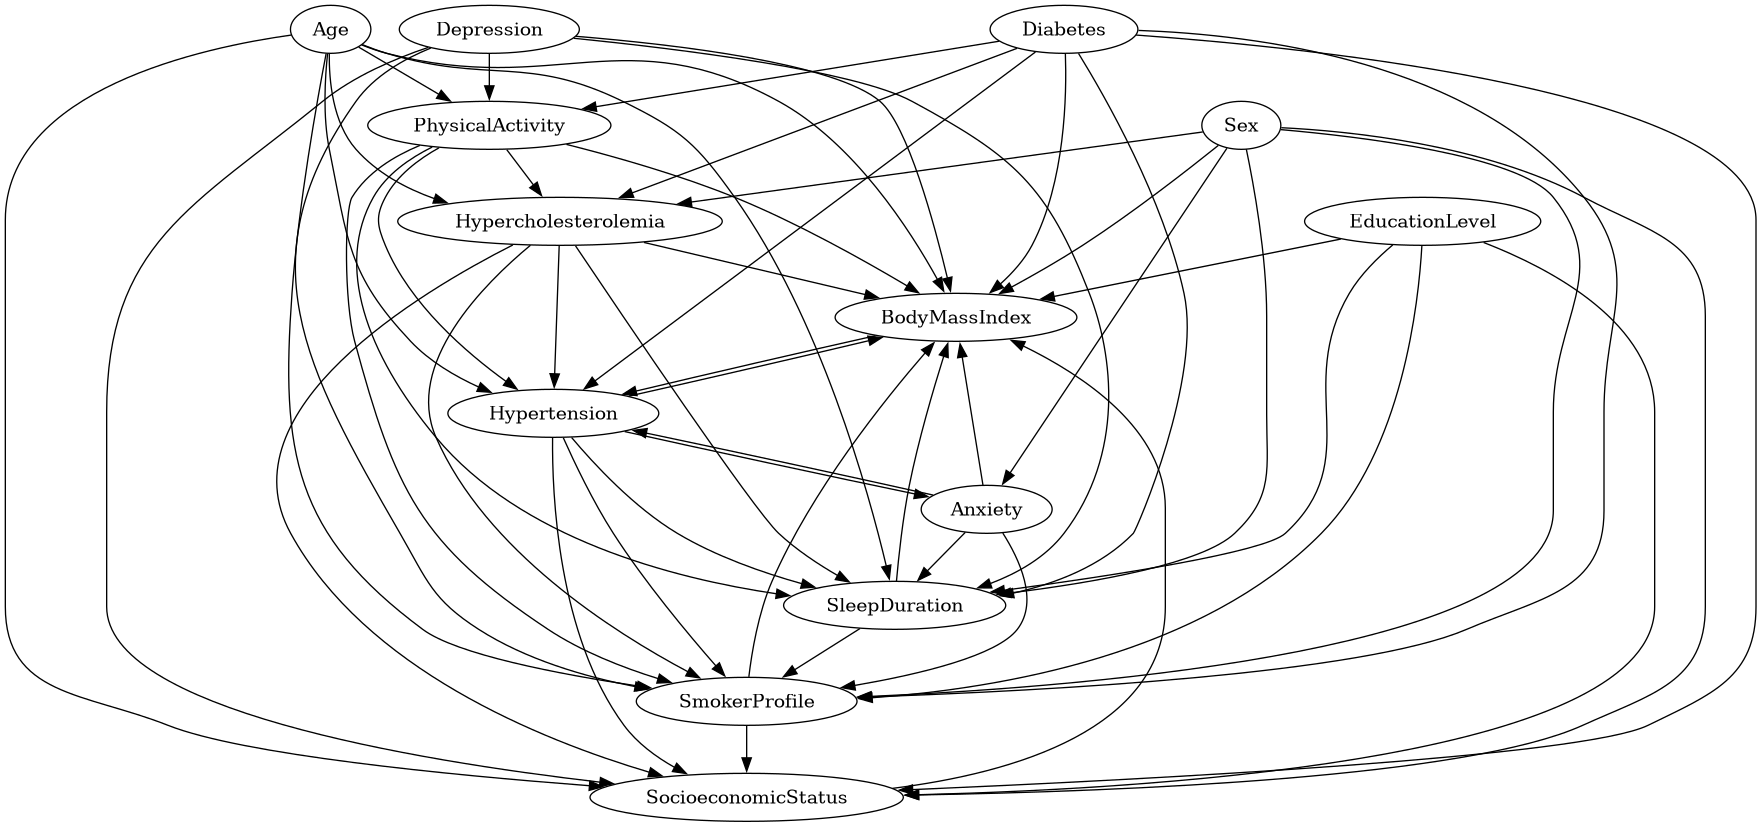

In [53]:
m = best_model.to_graphviz()
img = m.draw(format='png',prog="dot")
display(Image(img))